In [265]:
from PIL import Image
import numpy as np

file_path = 'E:\SamplePhotos\P1240036.jpg' # defien file path
im = Image.open(file_path) # import pictuate as Pillow Image object
pix = np.array(im) # convert to Numpy aray
h, w, d = orig_shape = tuple(pix.shape) # store original shape of array
pix_flat = np.reshape(pix, (h*w, d)) # flatten image for clustering
print(file_path)

E:\SamplePhotos\P1240036.jpg


In [266]:
## initiate sklearnex
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.cluster import KMeans # import K means
import matplotlib.pyplot as plt

no_clusters = 5 # start clustering from 5 clusters
clusterMin = 1 # set cluster min at 1 to enter while loop
while clusterMin > 0.01: # continue to increase number of clusters until the smallest cluster becomes suficently small to just be stripes
    print(no_clusters)
    kmeans = KMeans(n_clusters = no_clusters) # define cluster object
    cluster = kmeans.fit(pix_flat) # find clusters
    labels = cluster.labels_ # save cluster labels as a list
    percent = np.unique(labels, return_counts=True) # get counts # pixels in each cluster
    stripeColour = np.where(percent[1] == min(percent[1])) # return label of least frequent pixel
    clusterMin = min(percent[1]) / (h*w) # find fraction of picture occupied by smallest cluster
    print(clusterMin)
    no_clusters += 1 # increase cluster counter by 1

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


5
0.08228275
6
0.08182216666666667
7
0.07806033333333333
8
0.07194491666666666
9
0.031747
10
0.007352833333333334


In [292]:
labels = np.reshape(labels,(h,w)) # reshape labels array in 2d array (like picture)
stripes = np.where(labels == stripeColour) # get coordinates of all pixels which are a stripe colour
stripes = np.asarray(stripes) # build 2d array of stripe coordinates for clustering
stripes = np.transpose(stripes) # transpose array so as cordinates are pairs

In [400]:
stripes = stripes[np.lexsort((stripes[:,0], stripes[:,1]))] # sort stripes array by column values and then the row values
start_stop = np.where(np.diff(stripes[:,0], axis=0) != 1) # return index of locations where the difference between elements is not 1
start_stop = list(start_stop[0]) # convert start_stop to list
start_stop.insert(0,0) # insert a leading zero to mark start of first stripe
ind = [int(sum(start_stop[m:m+2])/2) for m in range(0, len(start_stop), 2)] # list comprehension --> finds the average of each index pair, converts to integer
stripes_Vexagerated = np.copy(stripes[ind,:]) # slice single value for each stripe and move into V-Exagerate
stripes_Vexagerated[:,0] = stripes_Vexagerated[:,0]*stripes_Vexagerated[:,0]

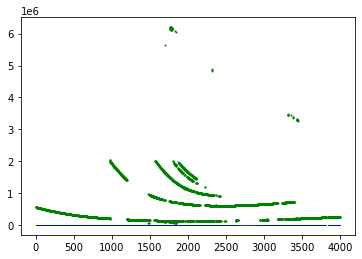

In [401]:
import matplotlib.pyplot as plt
plt.plot(stripes[:,1], stripes[:,0], 'o', markersize=0.01, color='blue')
plt.plot(stripes_Vexagerated[:,1], stripes_Vexagerated[:,0], 'o', markersize=1, color='green')


5000


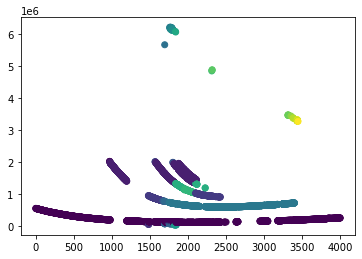

In [404]:
from sklearn.cluster import DBSCAN # import DB Scan
distance = 5000 # set inital eps (distance to jump in clustering) to 25
repeated_cluster = True # set to true to enter while loop

print(distance)
stripe_clusters = DBSCAN(eps=distance, min_samples=1).fit(stripes_Vexagerated) # fit clusters using DB SCAN
plt.scatter(stripes_Vexagerated[:,1], stripes_Vexagerated[:,0],c=stripe_clusters.labels_.astype(float))


In [ ]:
plt.scatter(stripes_Vexagerated[:,0])

In [ ]:

assesment_image = np.empty((h,w)) # make empty array to build image of stripe clusters in
for i in range(len(stripes_Vexagerated)): # iterate over all stripe coridnates
    n = stripes_Vexagerated[i,0] # assign n the row number of the stripe
    n = int(n/10) # remove vertical exageration
    m = stripes_Vexagerated[i,1] # assign m the column number of the stripe
    assesment_image[n,m] = stripe_clusters.labels_[i] # assign the label


repeated_cluster = np.any(np.diff(np.sort(assesment_image, axis=0), axis=0) == 0) # determine if the difference between any 2 elements adjacent elements                                                                                      is zero in the sorted columns, therefore there is a repeated value
distance -= 5
print(repeated_cluster)



In [ ]:

ass_image = np.empty(orig_shape) # make empty array to build image of stripe clusters in

for i in range(len(stripes_Vexagerated)): # iterate over all stripe coridnates
    n = stripes_Vexagerated[i,0] # assign n the row number of the stripe
    n = int(n/10) # remove vertical exageration
    m = stripes_Vexagerated[i,1] # assign m the column number of the stripe
    ass_image[n,m] = colours[i] # assign the colour according to the label

colours = [] # empty list to build colour for each cluster in
counter = 0
while counter < len(np.unique(stripe_clusters.labels_)): # build enough colour for each cluster
    colours.append(np.random.choice(range(256), size = 3)) # make random colour
    counter += 1
colours = np.array(colours) # convert colours to array
colours = colours[stripe_clusters.labels_] # assign colours to each test stripe

plt.imshow(ass_image.astype('uint8'))
plt.show()
plt.imsave('stripes.png', ass_image.astype('uint8'))

In [207]:
colours = [] # empty list to build colour for each cluster in
counter = 0
while counter < len(np.unique(stripe_clusters.labels_)): # build enough colour for each cluster
    colours.append(np.random.choice(range(256), size = 3)) # make random colour
    counter += 1
colours = np.array(colours) # convert colours to array
colours = colours[stripe_clusters.labels_] # assign colours to each test stripe

In [208]:
ass_image = np.empty(orig_shape) # make empty array to build image of stripe clusters in

for i in range(len(stripes)): # iterate over all stripe coridnates
    n = stripes[i,0] # assign n the row number of the stripe
    m = stripes[i,1] # assign m the column number of the stripe
    ass_image[n,m] = colours[i] # assign the colour according to the label



plt.imshow(ass_image.astype('uint8'))
plt.show()
plt.imsave('stripes.png', ass_image.astype('uint8'))


In [213]:
np.unique(assesment_image[:,2000], return_counts=True)

(array([ 0.,  6.,  9., 12., 15., 16.]),
 array([2968,   15,    5,    3,    4,    5], dtype=int64))